In [1]:
from fastai.collab import *
from fastai.tabular import *

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [2]:
user,item,title = 'userId','movieId','title'

That's all we need to create and train a model:

## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [3]:
path='data/movielens-100k/'

In [4]:
ratings = pd.read_csv(path+'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
movies = pd.read_csv(path+'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])

movies.drop(['date', 'N', 'url'], axis=1, inplace=True)
movies.head()

,movieId,title,g0,g1,g2,g3,g4,g5,g6,g7,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
len(ratings)

100000

In [7]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [8]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [9]:
data.show_batch()

userId,title,target
722,That Thing You Do! (1996),5.0
276,L.A. Confidential (1997),5.0
487,Leaving Las Vegas (1995),3.0
545,"Love Bug, The (1969)",3.0
187,Some Kind of Wonderful (1987),3.0


In [10]:
y_range = [0,5.5]

In [11]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


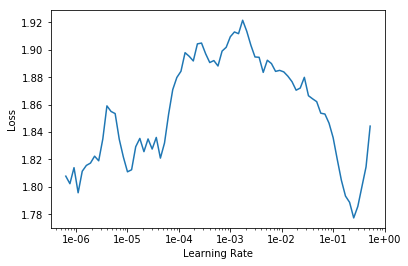

In [12]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [13]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
1,0.946635,0.950615,01:04
2,0.854319,0.879921,01:04
3,0.739564,0.831826,01:05
4,0.667756,0.808835,01:05
5,0.572098,0.807607,01:04


In [14]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [12]:
learn.load('dotprod');

In [13]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [14]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie bias

In [15]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [16]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [17]:
item0 = lambda o:o[0]

In [18]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3776),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2926), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2920), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2626),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2612), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2454), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2440), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(-0.2387), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2359), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2354), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2352), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2262), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2164), 'Hellraiser: Bloodline (1996)', 2.0),
 (tensor(-0.2097), 'Sgt. Bilko (1996)', 2.5675675675675675),
 (tensor(-0.2068), '

In [19]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.6109), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5605), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5602), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5584), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5290), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5106), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5086), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5062), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5003), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4889), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4741), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4725), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.4617), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4523), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4446), 'North by Northwest (1959)', 4.284916201117318)]

### Movie weights

In [20]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [21]:
weights = pd.DataFrame(movie_w.numpy())

In [22]:
weights['movie'] = top_movies
cols = list(weights.columns)
cols = [cols[-1]] + cols[:-1]
weights = weights[cols]

In [23]:
weights.shape

(1000, 41)

In [24]:
weights.head()

,movie,0,1,2,3,4,5,6,7,8,...,30,31,32,33,34,35,36,37,38,39
0,Star Wars (1977),0.450509,0.139392,-0.223595,-0.110323,0.238098,0.315389,-0.187934,-0.272431,0.196451,...,-0.212055,0.693330,-0.533029,-0.383238,0.262150,-0.119405,-0.532735,-0.034478,-0.236296,0.168962
1,Contact (1997),0.204237,0.051125,-0.446011,-0.081340,-0.291106,0.053521,-0.184440,-0.179308,-0.399747,...,-0.033167,0.203213,0.063708,-0.062772,0.219717,-0.309088,-0.150126,-0.071604,0.008044,0.052334
2,Fargo (1996),-0.430504,0.134639,-0.143155,-0.031531,0.321592,0.251934,-0.379862,-0.231453,-0.129051,...,0.296878,-0.005950,0.291010,0.146797,0.100275,-0.460219,-0.216949,0.312163,0.389049,0.291081
3,Return of the Jedi (1983),0.503116,0.030397,0.013628,-0.049398,0.122978,0.124420,0.025946,-0.096948,0.182393,...,-0.269124,0.410717,-0.447860,-0.430052,0.149528,-0.146232,-0.380747,-0.125910,-0.222196,0.106924
4,Liar Liar (1997),-0.242398,0.016740,0.181149,-0.133367,0.198355,0.095497,0.194158,0.142030,0.412312,...,-0.368942,0.213013,-0.250777,-0.329654,-0.018856,0.090567,-0.147769,0.414463,-0.365994,-0.263998


In [25]:
genres = movies[movies['title'].isin(top_movies)].drop('movieId', axis=1)

In [26]:
genres.drop_duplicates(subset='title', inplace=True)

In [27]:
genres.shape

(1000, 20)

In [28]:
genres.head()

,title,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,Toy Story (1995),0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,GoldenEye (1995),0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,Four Rooms (1995),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Get Shorty (1995),0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,Copycat (1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [29]:
weights.to_csv('data/movielens-100k/movie_weights.csv', index=False)
genres.to_csv('data/movielens-100k/movie_genres.csv', index=False)